In [16]:
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import os.path as osp
from tqdm import tqdm
import json
import requests

from sklearn.cluster import KMeans, SpectralClustering

In [2]:
def plot_image(image, size=(16, 8), title=None):
    plt.figure(figsize=size)
    plt.imshow(image, cmap="gray")
    if title:
        plt.title(title)
    plt.axis("off")
    plt.show()

In [3]:
image_list = [img for img in os.listdir("/mydata/FashionClassification/data/images/0") if img[-4:] == '.jpg']
print(f"{len(image_list)} images in total")

992 images in total


In [7]:
def reduce_dim(X, d):
    """
    X: 3d-np.array (batchsize, height, width)
    d: int, reduced dimensionality
    """
    pca = PCA(n_components=d)
    
    X_reduced = pca.fit_transform(X_flat)
    return X_reduced

def tsne_visual(X, d=2, label=None):
    """
    X: 2d-np.array, (batchsize, dim)
    d: int, dimensionality of visualization 
    """
    assert d in [2, 3]
    embedding = TSNE(n_components=d).fit_transform(X)
    if d == 2:
        if label is not None:
            plt.scatter(embedding[:, 0], embedding[:, 1], c=label)
        else:
            plt.scatter(embedding[:, 0], embedding[:, 1])
    else:
        fig = plt.figure(figsize=(16, 16))
        ax = fig.add_subplot(111, projection='3d')
        if label is not None:
            ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], c=label)
        else:
            ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2])
    plt.title("t-SNE Embedding")
    plt.show()
    
def clustering(X, cluster_algo=KMeans, n_clusters=11):
    algo = cluster_algo(n_clusters=n_clusters)
    y_pred = algo.fit_predict(X)
    return y_pred

In [10]:
X = []
root = "./data/images/0"

for img_name in tqdm(image_list):
    img_path = osp.join(root, img_name)
    try:
        image = Image.open(img_path)
        image = image.resize((224, 224))
    except IsADirectoryError as e:
        continue
    imarray = np.array(image)
    if len(imarray.shape)==3:
        imarray = np.array(image)[:, :, 1]
    X.append(imarray)
X = np.stack(X)
X_flat = X.reshape(992, -1)
X_reduced = reduce_dim(X_flat, 500)

100%|██████████| 992/992 [00:51<00:00, 19.22it/s]


In [11]:
y_kmeans = clustering(X_flat)
# y_dbscan = clustering(X_flat, cluster_algo=DBSCAN)
# y_spectral = clustering(X_flat, cluster_algo=SpectralClustering)

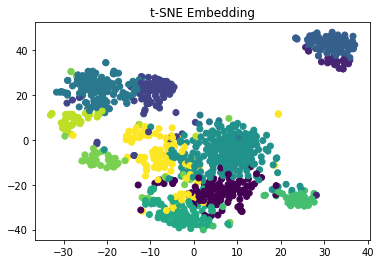

In [12]:
tsne_visual(X_flat, label=y_kmeans)

In [13]:
img2label = {}
for i, img_name in enumerate(image_list):
    img2label[img_name] = y_kmeans[i]

**Download image to directory according to their clustring**

In [20]:
server_url = "https://cdn.theyes.com/images/full/"
download = "./cluster_results"
if not os.path.exists(download):
    print(f"Creating {download}...")
    os.mkdir(download)
for img_idx, img_name in enumerate(image_list):
    response = requests.get(osp.join(server_url, img_name))
    out_dir = osp.join(download, str(y_kmeans[img_idx].item()))
    if not os.path.exists(out_dir):
        print(f"Creating {out_dir}...")
        os.mkdir(out_dir)
        
    with open(osp.join(out_dir, img_name), 'wb') as f:
        f.write(response.content)

**Adding labels to the input .json file**

In [21]:
with open("./data/product_data.json") as f:
    data = json.load(f)

for i, item in enumerate(data):
    url = item["image_url"]
    image_name = url.split("/")[-1]
    label = img2label[image_name]
    data[i]["label"] = int(label)

In [22]:
with open('product_data_kmeans.json', 'w') as file:
    json.dump(data, file, indent=4)